## Trend Calculation [Argentina]


#### Importing the Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
import openpyxl
from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

/Users/fazzy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Cleaning the Data 

In [2]:
# Import the Data from the xlsx file
filename = r"pwt100.xlsx"  

# Load the "Data" sheet and filter for Argentina
df = pd.read_excel(filename, sheet_name="Data", engine="openpyxl")
filtered_df = df[df.iloc[:, 1] == "Argentina"].copy()  # Make an explicit copy

# Index Match the Header
legend_df = pd.read_excel(filename, sheet_name="Legend", engine="openpyxl") # Read the legend sheet
mapping = dict(zip(legend_df.iloc[:, 0].str.strip(), legend_df.iloc[:, 1].str.strip()))  # Clean mapping keys
filtered_df = filtered_df.rename(columns=lambda col: mapping[col] if col in mapping else col)

# Clean to numeric and datetime format
filtered_df.iloc[:, 4:] = filtered_df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')  # Ensure numeric data
filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], format='%Y', errors='coerce')
filtered_df.reset_index(drop=True)

,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,Share of merchandise exports at current PPPs,Share of merchandise imports at current PPPs,Share of residual trade and GDP statistical discrepancy at current PPPs,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1"
0,ARG,Argentina,Argentine Peso,1950-01-01,5.030395e+04,5.010876e+04,17.091824,6.608833,2034.000000,1.816503,...,0.122540,-0.060423,-0.012842,0.193067,0.422730,0.273050,0.117665,0.107814,0.292420,NaN
1,ARG,Argentina,Argentine Peso,1951-01-01,5.267796e+04,5.133917e+04,17.457578,6.713252,2037.866753,1.830769,...,0.100497,-0.074776,-0.016469,0.213862,0.366893,0.277869,0.142259,0.118755,0.264830,NaN
2,ARG,Argentina,Argentine Peso,1952-01-01,4.767721e+04,4.685510e+04,17.815967,6.819321,2041.740856,1.845147,...,0.077847,-0.058380,-0.033148,0.229605,0.366508,0.296447,0.126297,0.130694,0.268225,NaN
3,ARG,Argentina,Argentine Peso,1953-01-01,4.952967e+04,4.991715e+04,18.168618,6.927065,2045.622325,1.859638,...,0.106709,-0.041785,-0.022161,0.230860,0.370191,0.315614,0.110863,0.102362,0.267306,NaN
4,ARG,Argentina,Argentine Peso,1954-01-01,5.183538e+04,5.225477e+04,18.517168,7.036511,2049.511172,1.874243,...,0.108594,-0.051525,-0.029199,0.229684,0.381629,0.327768,0.094007,0.093510,0.273750,8.502229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,ARG,Argentina,Argentine Peso,2015-01-01,9.148502e+05,9.131035e+05,43.075416,19.854450,1703.468539,2.975289,...,0.099057,-0.107307,-0.005448,0.814612,0.825699,0.446212,0.633933,0.620426,0.541800,1.215443
66,ARG,Argentina,Argentine Peso,2016-01-01,9.113680e+05,9.087713e+05,43.508460,19.723175,1646.512532,3.005213,...,0.102169,-0.100915,-0.013928,0.704616,0.736538,0.377989,0.627567,0.613758,0.467809,1.056981
67,ARG,Argentina,Argentine Peso,2017-01-01,1.026128e+06,1.022513e+06,43.937140,20.033661,1648.812832,3.035439,...,0.089602,-0.106394,0.011239,0.640839,0.770372,0.498410,0.637246,0.614945,0.512517,1.143677
68,ARG,Argentina,Argentine Peso,2018-01-01,1.025861e+06,1.021129e+06,44.361150,20.135071,1638.440039,3.065968,...,0.090679,-0.101482,0.036473,0.521541,0.660731,0.376825,0.664090,0.630823,0.412905,0.875886


## Trend calculation. Calculate a trend time paths for (the natural logs of) (i) realGDP and (ii) real GDP per capita. 

All at constant 2017 national prices using data over the whole sample. We will provide a simple template Python program that you can use to fit a time trend. Present two panels with the natural logarithm of each variable and the corresponding trend time path.

- As a robustness exercise, use the levels instead of log levels in the trend regression.

### Trend Time Paths

Disclaimer: We fit the trend paths based on a 20 year rolling window. The reason for this is because we believe these time paths are sufficiently long to not capture short term fluctuations but sufficiently short to see long term structural shifts in the economy
 - Additive Linear Model
 - Additive Quadratic Model
 - Exponential Linear Model
 - Exponential Quadratic

##### (i) Real GDP 

##### 1) Additive Linear Model

In [3]:
# Compute separate sample sizes for the subsample used for estimation and the whole sample

years = filtered_df["Year"].dt.year.values # Ensure the years array matches the length of Y
Yhat_add_linear = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
ymax = filtered_df["Year"].dt.year.values[-1]  # Maximum year in the data
ymin = filtered_df["Year"].dt.year.values[0]  # Minimum year in the data
Y = filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"].values

# Split years into 10-year periods
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 10-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_lin, b_add_lin = get_regression_coefs(Y_period, x1, x2)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_linear[t] = a_add_lin + b_add_lin * (idx + 1)  # Compute predictions


##### 2) Additive Quadratic Model

In [4]:
Yhat_add_quad = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 10-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term
    x3 = x2 ** 2  # Quadratic term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y_period, x1, x2,x3)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_quad[t] = a_add_quad + b_add_quad * (idx + 1) + c_add_quad * (idx + 1)**2  # Compute predictions


##### Plotting Additive Models

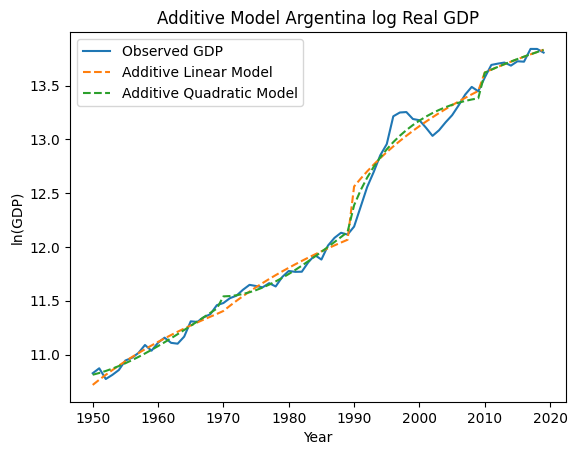

In [5]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"]), label="Observed GDP")
plt.plot(filtered_df["Year"], np.log(Yhat_add_linear), label="Additive Linear Model", linestyle="--")
plt.plot(filtered_df["Year"], np.log(Yhat_add_quad), label="Additive Quadratic Model", linestyle="--")

# Add labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Additive Model Argentina log Real GDP")
plt.legend()
plt.show()

##### 3) Exponential Linear Model

In [6]:
Yhat_exp_linear = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 20-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.exp(np.arange(1, len(Y_period) + 1))  

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        # Transform Y for exponential growth
        log_Y_period = np.log(Y_period)  # Take logarithm to linearize exponential trend -- Key difference!!
        a_exp_lin, b_exp_lin = get_regression_coefs(log_Y_period, x1, x2)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_exp_linear[t] = a_exp_lin + b_exp_lin * np.exp(idx + 1)  # Exponentiate to get back to original scale

##### 4) Exponential Quadratic Model

In [7]:
Yhat_exp_quad = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 20-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    t = np.arange(1, len(Y_period) + 1)  # Time indices for the block
    x2 = t  # Linear time trend
    x3 = t ** 2  # Quadratic time trend
    # Perform regression only if there are years in the block
    
    if len(Y_period) > 0:
        # Fit the regression model
        a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y_period, x1, x2, x3)

        # Predict Yhat for this period using exponential transformations during prediction
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_exp_quad[t] = (
                a_exp_quad
                + b_exp_quad * np.exp(idx + 1)  # Exponential of linear trend
                + c_exp_quad * np.exp((idx + 1) ** 2)  # Exponential of quadratic trend
            )

##### Plotting Exponential Models

- Note that there is a very large outlier in the exponential quadratic model! Hence it is currently excluded. Up for discussion what to do

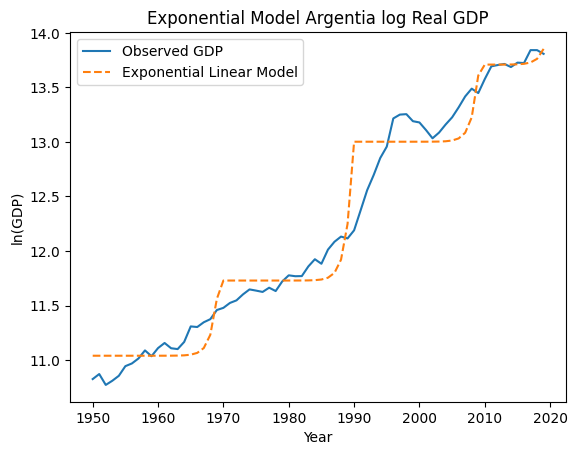

In [8]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"]), label="Observed GDP")
plt.plot(filtered_df["Year"], Yhat_exp_linear, label="Exponential Linear Model", linestyle="--")
 # plt.plot(filtered_df["Year"], Yhat_exp_quad, label="Exponential Quadratic Model", linestyle="--")
# Add labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Exponential Model Argentia log Real GDP")
plt.legend()
plt.show()

### BELOW IS A DIFFERENT WAY OF TACKLING PART A

In [9]:
# Initialise predicted values yhat
T_all = data["year"].max() - (ymin - 1) # number of all years in the data after ymin
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b_add_quad * (t + 1) + c_add_quad * (t+1) ** 2 # recall that Python indexing starts at 0

# Let us convert into log-units
yhat_add_quad= np.log(Yhat_add_quad)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],yhat_add_quad) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Additive Quadratic: GDP & trend")




NameError: name 'data' is not defined

##### (i) Real GDP - 3) Exponential Linear Model

In [ ]:
# 3.3) Exponential Linear Model

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = np.exp(t + 1) # recall that Python starts indexing at 0

a_exp_linear, b_exp_linear = get_regression_coefs(Y, x1, x2)

Text(0.5, 1.0, 'Exponential Linear: GDP & trend')

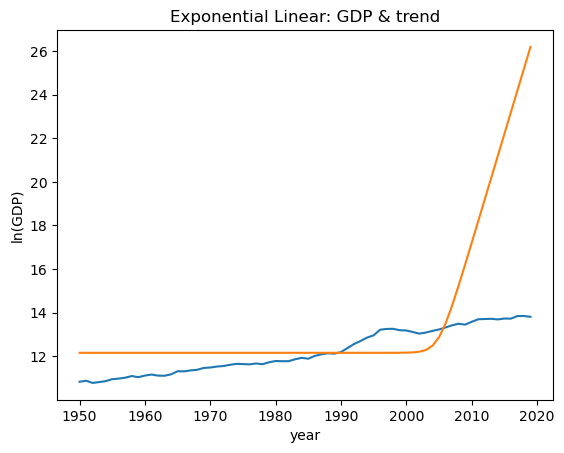

In [ ]:
# Initialise predicted values yhat
Yhat_exp_linear = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_linear[t] = a_exp_linear + b_exp_linear * np.exp(t+1)  # recall that Python indexing starts at 0

# Let us convert into log-units
Yhat_exp_linear= np.log(Yhat_exp_linear)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],Yhat_exp_linear) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")

##### (i) Real GDP - 4) Exponential Quadratic Model

In [ ]:
# 3.3) Exponential Quadratic Model

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor
scaling_factor = 1000
for t in range(T):
    x1[t] = 1.
    x2[t] = np.exp(t + 1) # recall that Python starts indexing at 0
    x3[t] = np.exp((t + 1) ** 2 / scaling_factor)

a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y, x1, x2,x3)

Text(0.5, 1.0, 'Exponential Linear: GDP & trend')

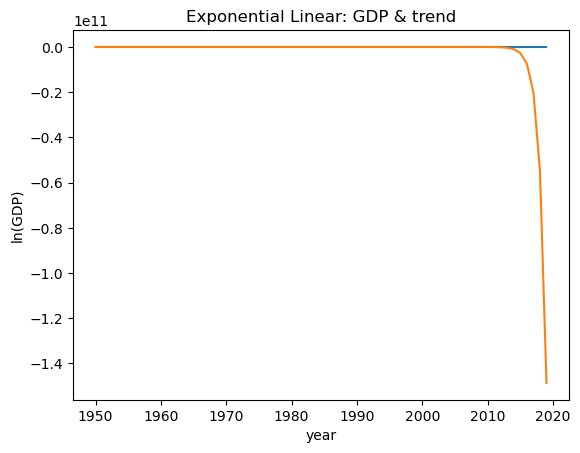

In [ ]:
# Initialise predicted values yhat
Yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_quad[t] = a_exp_quad + b_exp_quad * np.exp(t+1) + c_exp_quad * np.exp((t+1)**2/scaling_factor)  # recall that Python indexing starts at 0

# Let us convert into log-units
Yhat_exp_linear= np.log(Yhat_exp_linear)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],Yhat_exp_quad) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")

##### (ii) Real GDP per Capita

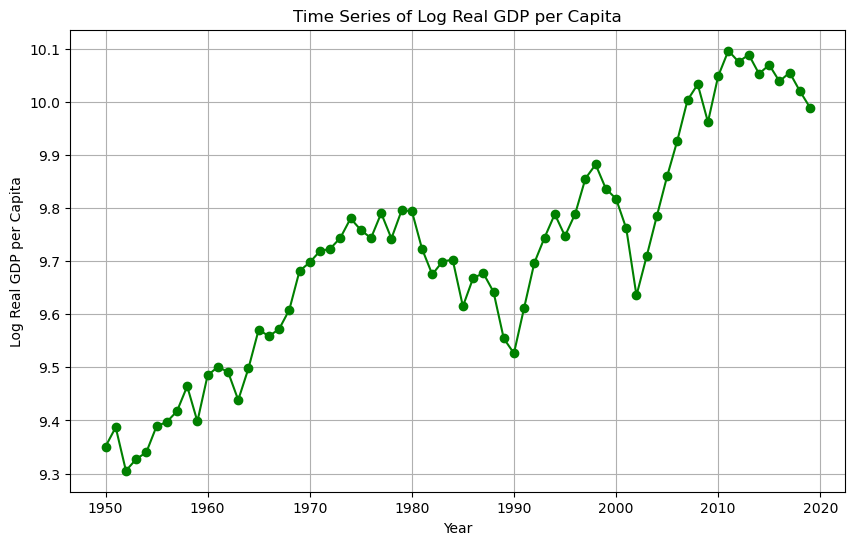

In [ ]:
# Columns for Real GDP and Population
gdp_column = "Real GDP at constant 2017 national prices (in mil. 2017US$)"
population_column = "Population (in millions)"
gdp_per_capita_column = "Log Real GDP per capita"

# Calculate Real GDP per capita and take the bnatural log
if all(col in filtered_df.columns for col in [gdp_column, population_column]):
    filtered_df[gdp_per_capita_column] = [
        np.log(gdp / pop) if pd.notnull(gdp) and pd.notnull(pop) and pop > 0 else np.nan
        for gdp, pop in zip(filtered_df[gdp_column], filtered_df[population_column])
    ]
else:
    raise KeyError(f"Columns '{gdp_column}' or '{population_column}' not found in DataFrame.")

# Plot the time series graph
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df[gdp_per_capita_column], color='green', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('Log Real GDP per Capita')
plt.title('Time Series of Log Real GDP per Capita')
plt.grid(True)
plt.show()


### Part B : Extracting TFP Measure

$$
Y = K^\alpha (AhL)^{1-\alpha}, \quad 0 < \alpha < 1
$$

We will be using a Labour-Augmented Cobb-Douglas Production Function as expressed above. 

$$
A = [hL]^{-1} \left[ YK^{-\alpha} \right]^{\frac{1}{1-\alpha}}
$$


In [11]:
# Assume alpha = 0.3
alpha = 0.3

filtered_df.reset_index(drop=True).columns

h = "Human capital index, based on years of schooling and returns to education; see Human capital in PWT9."
Y = "Real GDP at constant 2017 national prices (in mil. 2017US$)"
K = "Capital stock at constant 2017 national prices (in mil. 2017US$)"
l = "Number of persons engaged (in millions)"
avh = "Average annual hours worked by persons engaged"

# Use apply function to calculate TFP for each row based on the values in the columns
filtered_df['A (TFP)'] = filtered_df.apply(lambda row: (row[h] * row[l] * row[avh]) ** -1 * (row[Y] * (row[K] ** -alpha)) ** (1 / (1 - alpha)), axis=1)

filtered_df


,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,Share of merchandise imports at current PPPs,Share of residual trade and GDP statistical discrepancy at current PPPs,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1",A (TFP)
350,ARG,Argentina,Argentine Peso,1950-01-01,5.030395e+04,5.010876e+04,17.091824,6.608833,2034.000000,1.816503,...,-0.060423,-0.012842,0.193067,0.422730,0.273050,0.117665,0.107814,0.292420,NaN,6.212198
351,ARG,Argentina,Argentine Peso,1951-01-01,5.267796e+04,5.133917e+04,17.457578,6.713252,2037.866753,1.830769,...,-0.074776,-0.016469,0.213862,0.366893,0.277869,0.142259,0.118755,0.264830,NaN,6.315632
352,ARG,Argentina,Argentine Peso,1952-01-01,4.767721e+04,4.685510e+04,17.815967,6.819321,2041.740856,1.845147,...,-0.058380,-0.033148,0.229605,0.366508,0.296447,0.126297,0.130694,0.268225,NaN,5.487335
353,ARG,Argentina,Argentine Peso,1953-01-01,4.952967e+04,4.991715e+04,18.168618,6.927065,2045.622325,1.859638,...,-0.041785,-0.022161,0.230860,0.370191,0.315614,0.110863,0.102362,0.267306,NaN,5.520595
354,ARG,Argentina,Argentine Peso,1954-01-01,5.183538e+04,5.225477e+04,18.517168,7.036511,2049.511172,1.874243,...,-0.051525,-0.029199,0.229684,0.381629,0.327768,0.094007,0.093510,0.273750,8.502229,5.503377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,ARG,Argentina,Argentine Peso,2015-01-01,9.148502e+05,9.131035e+05,43.075416,19.854450,1703.468539,2.975289,...,-0.107307,-0.005448,0.814612,0.825699,0.446212,0.633933,0.620426,0.541800,1.215443,6.189871
416,ARG,Argentina,Argentine Peso,2016-01-01,9.113680e+05,9.087713e+05,43.508460,19.723175,1646.512532,3.005213,...,-0.100915,-0.013928,0.704616,0.736538,0.377989,0.627567,0.613758,0.467809,1.056981,6.150012
417,ARG,Argentina,Argentine Peso,2017-01-01,1.026128e+06,1.022513e+06,43.937140,20.033661,1648.812832,3.035439,...,-0.106394,0.011239,0.640839,0.770372,0.498410,0.637246,0.614945,0.512517,1.143677,6.158897
418,ARG,Argentina,Argentine Peso,2018-01-01,1.025861e+06,1.021129e+06,44.361150,20.135071,1638.440039,3.065968,...,-0.101482,0.036473,0.521541,0.660731,0.376825,0.664090,0.630823,0.412905,0.875886,5.847733


#### Plotting a time-series for TFP

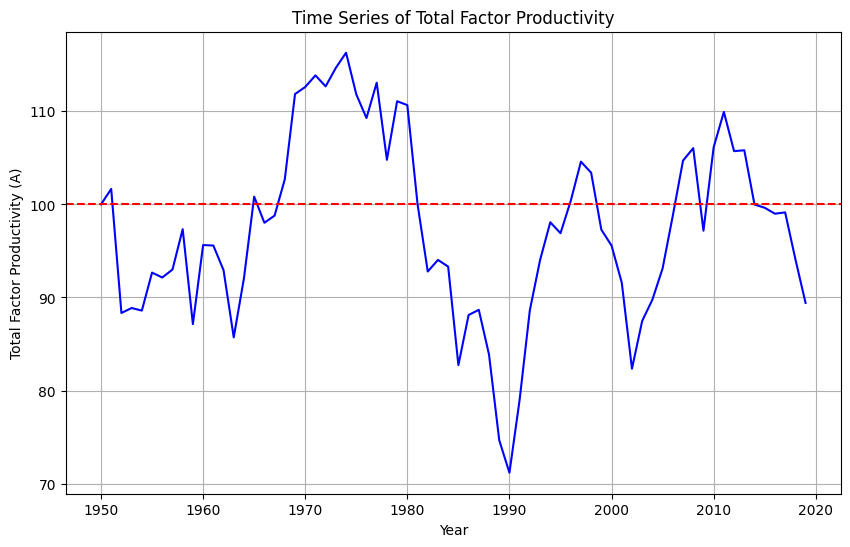

In [12]:
# Express the TFP as a value relative to the first year where 1950 is 100
filtered_df['A (TFP) Relative'] = 100 * filtered_df['A (TFP)'] / filtered_df.loc[filtered_df['Year'].dt.year == 1950, 'A (TFP)'].values[0]


# Create a time-series graph plotting the TFP over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['A (TFP) Relative'], color='blue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Factor Productivity (A)')
plt.title('Time Series of Total Factor Productivity')
plt.grid(True)
# Add horizontal line at Y = 100
plt.axhline(y=100, color='r', linestyle='--')
plt.show()

### Part C : Growth Accounting

In [13]:
def compute_growth_rate(X):
    #np.log is the natural logarithm by default in numpy
    #use of index slicing, e.g. X[1:] are all values starting from the second element, X[:-1] all elements up until (but not including) the last element
    return np.log(X[1:] / X[:-1])

dY = compute_growth_rate(filtered_df[Y].values)
dA = compute_growth_rate(filtered_df['A (TFP)'].values)
dK = compute_growth_rate(filtered_df[K].values)
dL = compute_growth_rate((filtered_df[l] * filtered_df[avh]).values)
dh = compute_growth_rate(filtered_df[h].values)


$$
\begin{aligned}
\text{contr\_K} &= \alpha \cdot \frac{g_K}{g_Y} \\
\text{contr\_L} &= (1 - \alpha) \cdot \frac{g_L}{g_Y} \\
\text{contr\_A} &= (1 - \alpha) \cdot \frac{g_A}{g_Y}
\end{aligned}
$$

In [14]:
# calculate contributions
contrib_dK = alpha * dK / dY
contrib_dL = (1 - alpha) * dL / dY
contrib_dA = (1 - alpha) * dA / dY
contrib_dh = (1-alpha) * dh / dY
year = filtered_df['Year'].dt.year.values

# Display growth rates
print("\t == year by year growth rate ==\n")
print("\t year \t \t ln(Y_t/Y_{t-1}) ")
print("\t ------- \t ------ ")
for y1, y2, growth in zip(year[:-1], year[1:], dY):
    print(f"\t {y1:.0f}-{y2:.0f} \t {growth:.4f}")

	 == year by year growth rate ==

	 year 	 	 ln(Y_t/Y_{t-1}) 
	 ------- 	 ------ 
	 1950-1951 	 0.0574
	 1951-1952 	 -0.0614
	 1952-1953 	 0.0413
	 1953-1954 	 0.0320
	 1954-1955 	 0.0675
	 1955-1956 	 0.0260
	 1956-1957 	 0.0377
	 1957-1958 	 0.0640
	 1958-1959 	 -0.0496
	 1959-1960 	 0.1031
	 1960-1961 	 0.0320
	 1961-1962 	 0.0064
	 1962-1963 	 -0.0374
	 1963-1964 	 0.0748
	 1964-1965 	 0.0880
	 1965-1966 	 0.0024
	 1966-1967 	 0.0275
	 1967-1968 	 0.0504
	 1968-1969 	 0.0877
	 1969-1970 	 0.0315
	 1970-1971 	 0.0369
	 1971-1972 	 0.0206
	 1972-1973 	 0.0368
	 1973-1974 	 0.0526
	 1974-1975 	 -0.0059
	 1975-1976 	 -0.0001
	 1976-1977 	 0.0619
	 1977-1978 	 -0.0327
	 1978-1979 	 0.0678
	 1979-1980 	 0.0144
	 1980-1981 	 -0.0557
	 1981-1982 	 -0.0321
	 1982-1983 	 0.0403
	 1983-1984 	 0.0199
	 1984-1985 	 -0.0721
	 1985-1986 	 0.0690
	 1986-1987 	 0.0250
	 1987-1988 	 -0.0197
	 1988-1989 	 -0.0727
	 1989-1990 	 -0.0135
	 1990-1991 	 0.0998
	 1991-1992 	 0.0981
	 1992-1993 	 0.0606
	 1

In [15]:
# Compute yearly intervals of the form "2000-2001"
intvls = np.array([f"{y1}-{y2}" for y1, y2 in zip(year[:-1], year[1:])])

# Fill in the dataframe
df_contribs = pd.DataFrame(
    data = np.hstack((intvls[:, None], contrib_dK[:, None], contrib_dL[:, None], contrib_dA[:, None], contrib_dh[:, None])),
    columns = ['year', 'K contribution', 'L contribution', 'A contribution', 'h contribution']
)

# Specify the data types for specific columns (it would be more efficient to define dataypes already before creating dataframe)
df_contribs = df_contribs.astype({
    'year': 'object',
    'K contribution': 'float64',
    'L contribution': 'float64',
    'A contribution': 'float64',
    'h contribution': 'float64'
})

# Set index
df_contribs = df_contribs.set_index('year')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Dispaly contribution table
print(df_contribs)

           K contribution  L contribution  A contribution  h contribution
year                                                                     
1950-1951          0.4887          0.2144          0.2014          0.0954
1951-1952         -0.3130         -0.2003          1.6025         -0.0892
1952-1953          0.4675          0.2977          0.1023          0.1325
1953-1954          0.5134          0.3840         -0.0682          0.1709
1954-1955          0.2694          0.1822          0.4672          0.0811
...                   ...             ...             ...             ...
2014-2015          0.2353          0.5944         -0.0896          0.2600
2015-2016         -0.2351          1.3532          0.2151         -0.3332
2016-2017          0.2434          0.4523          0.0384          0.2660
2017-2018         -0.2005          0.0351          1.4441         -0.2787
2018-2019         -0.1067         -0.2188          1.6459         -0.3204

[69 rows x 4 columns]


In [ ]:
#  Calculating Trend for Selected Sub-Periods





### Part D : Extracting Labour Productivity

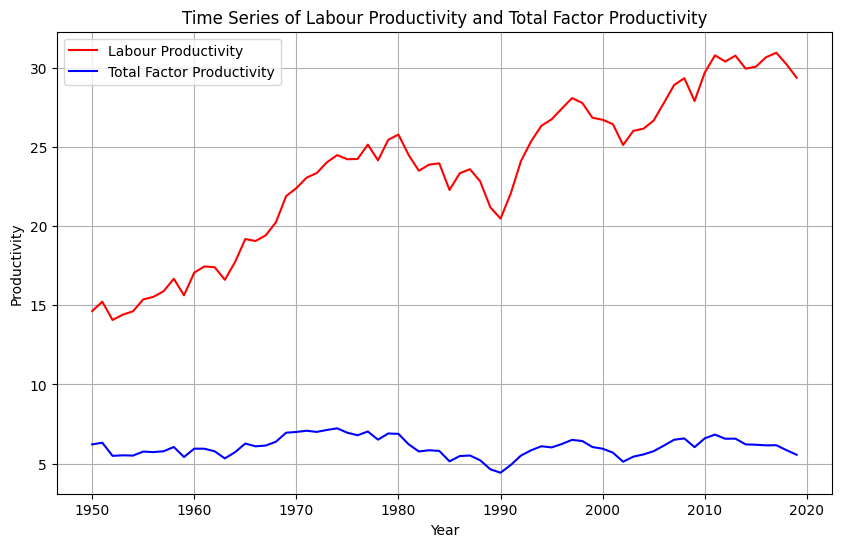

In [ ]:
# I want to create a new column in the DataFrame that calculates the labour productivity which is the ratio of Y/L
filtered_df['Labour Productivity'] = filtered_df['Real GDP at constant 2017 national prices (in mil. 2017US$)'] / (filtered_df['Number of persons engaged (in millions)'] * filtered_df['Average annual hours worked by persons engaged'])

# Plot a time series graph of labour productivity and total factor productivity, normalise y-values using log
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['Labour Productivity'], color='red', linestyle='-', label='Labour Productivity')
plt.plot(filtered_df['Year'], filtered_df['A (TFP)'], color='blue', linestyle='-', label='Total Factor Productivity')
plt.xlabel('Year')
plt.ylabel('Productivity')
plt.title('Time Series of Labour Productivity and Total Factor Productivity')
plt.legend()
plt.grid(True)
plt.show()


## Description Part of the Project

### 2. Solow Model - Is the Solow model capable of explaining part of the growth developments in your allocated country?

### 4. Romer model - Is the Romer model useful to explain part of the growth patterns in your country? This does not have to be the Romer model with constant parameters. Also, it is perfectly fine to be critical of the Romer model if your country does not provide support.